In [8]:
from torch.utils.data import Dataset
import torch
import numpy as np
from utils import get_ray_directions, get_rays
import os
import json
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Tuple
import lightning as L
from rendering import rendering

from dataset import LegoDataset, LegoDataModule
from model import Nerf


In [9]:
lego_dataset = LegoDataset(
    root_dir="dataset/lego/", split="train", img_shape=(200, 200)
)

/home/stanley/Documents/shid/nerf_pytorch_lightning/utils.py:69: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [10]:

train_dataloader = DataLoader(
            torch.cat(
                (
                    lego_dataset.all_rays_origin.type(torch.float),
                    lego_dataset.all_rays_direction.type(torch.float),
                    lego_dataset.all_rgbs.type(torch.float),
                ),
                dim=1,
            ),
            batch_size=1024,
            num_workers=3,
            shuffle=True,
        )

image_1_4 = int(lego_dataset.img_shape[0] * (1 / 4))
image_3_4 = int(lego_dataset.img_shape[0] * (3 / 4))
warmup_dataloader = DataLoader(
                torch.cat(
                    (
                        lego_dataset.all_rays_origin.reshape(
                            len(lego_dataset),
                            lego_dataset.img_shape[0],
                            lego_dataset.img_shape[1],
                            3,
                        )[:, image_1_4:image_3_4, image_1_4:image_3_4, :].reshape(
                            -1, 3
                        ).type(torch.float),
                        
                        lego_dataset.all_rays_direction.reshape(
                            len(lego_dataset),
                            lego_dataset.img_shape[0],
                            lego_dataset.img_shape[1],
                            3,
                        )[:, image_1_4:image_3_4, image_1_4:image_3_4, :].reshape(
                            -1, 3
                        ).type(torch.float),
                        
                        lego_dataset.all_rgbs.reshape(
                            len(lego_dataset),
                            lego_dataset.img_shape[0],
                            lego_dataset.img_shape[1],
                            3,
                        )[:, image_1_4:image_3_4, image_1_4:image_3_4, :].reshape(
                            -1, 3
                        ).type(torch.float),
                    ),
                    dim=1,
                ),
                batch_size=1024,
                num_workers=3,
                shuffle=True,
            )

In [4]:
lego_dataset.all_rays_origin[0]

tensor([-0.0538,  3.8455,  1.2081], dtype=torch.float64)

In [7]:
len(warmup_dataloader)

3907

In [11]:
def training(model, optimizer, scheduler, dataloader,tn, tf, nb_bins, nb_epochs, device= 'cpu'):
    
    training_loss = []
    
    progress_bar = tqdm(
    enumerate(dataloader), 
    total=len(dataloader),
    )
    
    for epoch in range(nb_epochs):
        progress_bar.set_description(f"Training Epoch: {epoch}")
        for idx ,batch in progress_bar:
            origin = batch[:, :3].to(device)
            direction = batch[:, 3:6].to(device)
            
            target = batch[:, 6:].to(device)
            
            prediction = rendering(model, origin, direction, tn, tf, nb_bins, device)
            
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix(
            {
                "loss": loss.item() 
            }
            )
            training_loss.append(loss.item())
            
        scheduler.step()
        
        torch.save(model.cpu(), 'models/model_nerf')
        model.to(device)

In [1]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#hyperparams
tn = 2.0
tf = 6.0
nb_epochs = 16
learning_rate = 1e-3
gamma = 0.5
nb_bins = 100

model = Nerf().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones= [2, 4, 8], gamma=gamma)


#warmup on 1 epoch
training_loss = training(model, optimizer, scheduler, warmup_dataloader, tn, tf, nb_bins, 1, device)
plt.plot(training_loss)
plt.show()

# training_loss = training(model, optimizer, scheduler, train_dataloader, tn, tf, nb_bins, nb_epochs, device)
# plt.plot(training_loss)
# plt.show()

NameError: name 'torch' is not defined

In [6]:
torch.save(model.cpu(), 'models/model_nerf')
model.to(device)

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=257, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): Si

In [22]:
lego_dataset.all_rays_direction.reshape(100,-1,3)[0].shape
lego_dataset.all_rays_origin.reshape(100,-1,3)[0].shape

torch.Size([160000, 3])

In [18]:

def mse2psnr(mse_loss):
    return 20 * np.log10(1 / np.sqrt(mse_loss))
@torch.inference_mode()
def test(model, origin, direction, tn, tf, nb_bins=100, chunk_size=20, height=400, width=400, target=None):
   
    with torch.inference_mode():
        model.eval()
        origin = origin.chunk(chunk_size)
        direction = direction.chunk(chunk_size)
        
        image = []
        for origin_batch, direction_batch in zip(origin, direction): #zip to interate both lists at the same time
            img_batch = rendering(model, origin_batch, direction_batch, tn, tf, nb_bins, device=origin_batch.device)
            image.append(img_batch) #[N, 3]
                    
        image = torch.cat(image) # [H*W, 3]
        image = image.reshape(height, width, 3).cpu().numpy() #no need for .data as there are no gradients!
        
        if target is not None:
            # mse = nn.MSELoss()
            # loss = mse(image, target)
            loss = ((image - target)**2).mean() #same as mean squared errorfunction
            psnr = mse2psnr(loss)
            return image, loss, psnr
        
        else:
            return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


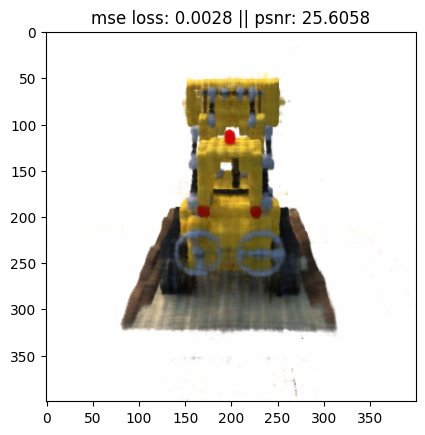

In [25]:
img, mse, psnr = test(model,
     lego_dataset.all_rays_origin.reshape(100,-1,3)[0].to(device).type(torch.float),
     lego_dataset.all_rays_direction.reshape(100,-1,3)[0].to(device).type(torch.float),
     tn, tf,
     nb_bins=100,
     chunk_size=20,
     target=lego_dataset.all_rgbs.reshape(100,400,400,3)[0].numpy())

plt.title(f"mse loss: {mse:.4f} || psnr: {psnr:.4f}")
plt.imshow(img)

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm
import json
from pathlib import Path
import lightning as L
from dataset import LegoDataModule
from model import NeRFLightning

from rendering import rendering
from model import Sphere
from config import ORIGIN, RADIUS, HEIGHT, WIDTH, SAVE_DIR, DATA_DIR, IMG_SIZE, LEARNING_RATE, TN, TF, NB_BINS, GAMMA, ACCELERATOR, DEVICES, PRECISION, MAX_EPOCHS
from loss import mse_loss

if __name__ == '__main__':
    dm = LegoDataModule(data_dir=DATA_DIR, img_size=(IMG_SIZE, IMG_SIZE), batch_size=1024, num_workers=3)
    model = NeRFLightning(LEARNING_RATE, TN, TF, NB_BINS, GAMMA)
    trainer = L.Trainer(accelerator=ACCELERATOR,
                        devices=DEVICES,
                        precision=PRECISION,
                        max_epochs=MAX_EPOCHS,
                        min_epochs=0,
                        fast_dev_run=False,
                        reload_dataloaders_every_n_epochs=1)
    
    trainer.fit(model=model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/stanley/miniconda3/envs/nerf_pl/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/stanley/miniconda3/envs/nerf_pl/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/stanley/Documents/shid/nerf_pytorch_lightning/utils.py:69: To copy construct from a te

Using warmup dataloader
Epoch 0: 100%|██████████| 3907/3907 [12:16<00:00,  5.31it/s, v_num=8, loss=0.00678][INFO] Scheduler Step.
Using regular dataloader
Epoch 1:   0%|          | 67/15625 [00:17<1:09:26,  3.73it/s, v_num=8, loss=0.00397, psnr=19.00]

/home/stanley/miniconda3/envs/nerf_pl/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [26]:
lego_dataset[0]['rgbs'].shape

/home/stanley/Documents/shid/nerf_pytorch_lightning/utils.py:69: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([160000, 3])

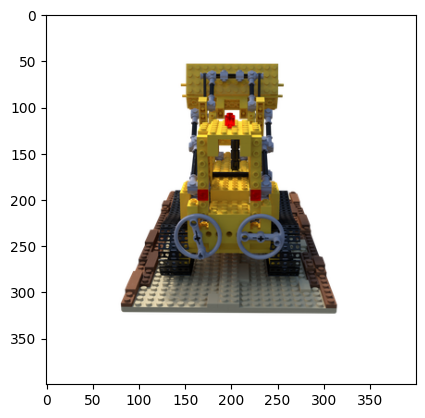

In [8]:
plt.imshow(lego_dataset[0]['rgbs'])

In [11]:
lego_dataset.all_rgbs.shape

torch.Size([16000000, 3])

In [23]:
lego_dataset.all_rgbs[1].to(device='cuda').cpu().detach().numpy()

array([1., 1., 1.], dtype=float32)